<a href="https://colab.research.google.com/github/yishairasowsky/Sefaria-Project/blob/master/ML/topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd

In [0]:
prayer_df = pd.read_csv('/content/prayer-sources.csv', 
                        # encoding="latin-1"
                        encoding="utf-8"
                        )
not_prayer_df = pd.read_csv('/content/not-prayer-sources.csv', 
# not_prayer_df = pd.read_csv('/content/not-prayer-sources-more.csv', 
                            # encoding="latin-1"
                              encoding="utf-8"
                            )

In [957]:
prayer_df.sample(3)

,Ref,En,He
103,Sifrei Devarim 41:25-27,"Variantly: ""and to serve Him"": This is prayer. — But perhaps it is service, literally. It is, th...","ד""א: ""לעבדו"" - זו תפילה. זו תפלה, או אינו אלא עבודה? - ת""ל ""בכל לבבך ובכל נפשך ובכל מאדך"", וכי י..."
872,"Sefat Emet, Deuteronomy, Ki Tavo 11:3",NaN,"במדרש אם שמוע ת' דלת לפנים מדלת כו' לשקוד על דלתותי כו' מזוזת פתחי כשם שהמזוזה קבוע כו' א""א עושה..."
742,Proverbs 28:9,"He that turneth away his ear from hearing the law, Even his prayer is an abomination.",מֵסִ֣יר אָ֭זְנוֹ מִשְּׁמֹ֣עַ תּוֹרָ֑ה גַּֽם־תְּ֝פִלָּת֗וֹ תּוֹעֵבָֽה׃


In [958]:
prayer_df['is_prayer'] = 'yes'
prayer_df = prayer_df[['En','is_prayer']]

prayer_df.tail(3)

,En,is_prayer
1049,"It is true that you are the one who judges, and reproves, who knows all, and bears witness, who ...",yes
1050,"In these Berachot (blessings) we bow down: the first Beracha (blessing) [of Shemoneh Esreh], in ...",yes
1051,On seeds he says [the Beracha (blessing)] Borei Minei Zerayim (Who created different types of se...,yes


In [959]:
not_prayer_df.sample(3)

,Ref,En,He,Topics
596,Chullin 42a:5,"Likewise, if an animal fell from the roof, or if the majority of its ribs were fractured, or if ...",נפלה מן הגג נשתברו רוב צלעותיה ודרוסת הזאב רבי יהודה אומר דרוסת הזאב בדקה ודרוסת ארי בגסה דרוסת ...,hilchot-tereifot|limbs|terefah|kashrut|laws-of-the-prohibitions-of-eating-meat
367,Magen Avraham 494:6,"There are many reasons for eating dairy, I will copy the reason written in the Zohar: the previo...","חלב . יש הרבה טעמים ומ""כ הטעם דאיתא בזוהר שאותן ז' שבועות היו לישראל שבעה נקיים דוגמת אשה המיטהר...",milk|cheese-cake|shavuot
574,Midrash Tehillim 18:1,NaN,למנצח לעבד ה'. זה שאמר הכתוב (תהלים עד טז) לך יום אף לך לילה. ר' יודן בשם ר' יהודה אמר כל מה שאמ...,praise-of-god|miracles|psalms


In [960]:
not_prayer_df['is_prayer'] = 'no'
not_prayer_df = not_prayer_df[['En','is_prayer']]
not_prayer_df.sample(3)

,En,is_prayer
278,It is taught: caravans of [Jewish] people that were on a journey and met idol worshipers who sai...,no
1049,who said to another: I am hereby selling to you all of the property that I own of the house of b...,no
571,"One does not protest against poor gentiles who come to take gleanings, forgotten sheaves, and th...",no


In [961]:
all_prayer_frames = [prayer_df, not_prayer_df]
all_prayer_df = pd.concat(all_prayer_frames)
all_prayer_df.reset_index(inplace=True)
all_prayer_df=all_prayer_df.rename(columns = {'En':'english_text'})


# all_prayer_df.style.set_properties({'align': 'right'})

# all_prayer_df.tail(3)
all_prayer_df.sample(5)
# all_prayer_df.loc[[345]]

,index,english_text,is_prayer
574,574,NaN,yes
1657,605,"Rav and Shmuel both said: Actually, the case of the woman eating the dates one by one is referri...",no
1802,750,NaN,no
1416,364,NaN,no
1319,267,"His head is as the most fine gold, His locks are curled, And black as a raven.",no


In [962]:
del all_prayer_df['index']

all_prayer_df.sample(3)

,english_text,is_prayer
914,[A Psalm] of David. The LORD is my light and my salvation; whom shall I fear? The LORD is the st...,yes
1471,"לה' מאד BEFORE THE LORD, EXCEEDINGLY — They knew their Master and yet intentionally rebelled aga...",no
1687,"The verse continues: “Therefore the king was very wrathful, and his anger burned in him” (Esther...",no


In [963]:
print("Before dropping duplicates",all_prayer_df.shape)
all_prayer_df.drop_duplicates(inplace=True)
print("After dropping duplicates",all_prayer_df.shape)

print("\nNulls before dropping:",all_prayer_df.isnull().sum()[0])
all_prayer_df.dropna(inplace=True)
print("Nulls after dropping:",all_prayer_df.isnull().sum()[0])

# all_prayer_df.isnull().sum()
# all_prayer_df.sample(5)

Before dropping duplicates (2103, 2)
After dropping duplicates (1223, 2)

Nulls before dropping: 2
Nulls after dropping: 0


In [964]:
shape = all_prayer_df.shape
print(f"{shape[0]} rows and {shape[1]} columns")

1221 rows and 2 columns


In [965]:
all_prayer_df['is_prayer'] = all_prayer_df['is_prayer'].map({'no': 0, 'yes': 1})
all_prayer_df.sample(5)

,english_text,is_prayer
25,"Rabbi Ḥanina waited for him until he completed his prayer. When he finished, Rabbi Ḥanina asked ...",1
2099,"ויעקבני THAT HE HATH SUPPLANTED ME — Explain it as the Targum renders it, וחכמני, which means “a...",0
1538,"Rava said: Both instances of the word “good” in the verse are superfluous. If so, let the verse ...",0
933,"Rabbi Eliezer says: if a man makes his prayers fixed, it is not [true] supplication. Rabbi Joshu...",1
2054,"ויתחזק ישראל וישב על המטה . Israel's ability to strengthen himself and sit on ""the bed,"" was due...",0


In [966]:
print('Prayer:', (all_prayer_df.is_prayer.values == 1).sum())
print('Not prayer:', (all_prayer_df.is_prayer.values == 0).sum())

Prayer: 553
Not prayer: 668


In [967]:
import re
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_ \b\d+\b]')
STOPWORDS = set(stopwords.words('english'))

def process_text(text):
    #  text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# whitelist = set('abcdefghijklmnopqrstuvwxyz ZXCVBNMASDFGHJKLQWERTYUIOP')
# genres['movie_id'] = genres['movie_id'].astype(str)

# def process_text(text):
#     '''
#     1. Keep only letters and spaces
#     2. Remove stopwords
#     3. Return str of clean text words
#     '''
#     #1
#     chars_str = ''.join(filter(whitelist.__contains__, text))
#     #2
#     clean_words = [word.lower() for word in chars_str.split() if word.lower() not in stopwords.words('english')]
#     #3
#     return ' '.join(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [968]:
sample_text = '''aBC.!@#$%^&    c*(בחתו ‎‎‎ או‎ בקרחתו — une...
233 the gns: ac ...
1041    7. a pien p'''
process_text(sample_text)

'abc # c une233 gns ac 1041 7 pien p'

In [969]:
all_prayer_df.sample(5)

,english_text,is_prayer
843,What is wrong with this theory is that if Pharaoh wanted to unmask Moses as a fraud he did not r...,1
1776,§ Having quoted an allusion from the verse: “For on account of a harlot a man is brought to a lo...,0
835,"The author now proceeds to explain the thirteen attributes in the traditional way, including the...",1
1889,"§ The mishna teaches: And one who eats unslaughtered animal or bird carcasses, or tereifot , or ...",0
1222,"The one of uncertain descent said: I am the son of the deceased, and therefore, as the only heir...",0


In [970]:
processed_df = all_prayer_df
processed_df['english_text'] = processed_df['english_text'].apply(process_text)
processed_df.head(5)

,english_text,is_prayer
0,another abba binyamins statements regard laws prayer taught baraita abba binyamin says two peopl...,1
1,taught baraita abba binyamin said ones prayer fully heard synagogue stated regard king solomons ...,1
2,additionally ravin bar rav adda said rabbi yitzak said one accustomed come synagogue come one da...,1
3,similarly taught baraita rabbi yishmael ben elisha high priest said yom kippur entered innermost...,1
4,meaning written let prayer unto lord time favor god abundance mercy answer truth salvation psalm...,1


In [971]:
# all_prayer_df['En'] = all_prayer_df['En'].apply(stemming)
# all_prayer_df.head()
stemmed_df = processed_df
stemmed_df['english_text'] = stemmed_df['english_text'].apply(stemming)
stemmed_df.head()

,english_text,is_prayer
0,anoth abba binyamin statement regard law prayer taught baraita abba binyamin say two peopl enter...,1
1,taught baraita abba binyamin said one prayer fulli heard synagogu state regard king solomon pray...,1
2,addit ravin bar rav adda said rabbi yitzak said one accustom come synagogu come one day holi one...,1
3,similar taught baraita rabbi yishmael ben elisha high priest said yom kippur enter innermost san...,1
4,mean written let prayer unto lord time favor god abund merci answer truth salvat psalm 6914 appe...,1


In [0]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# prayer_words = ' '.join(list(all_prayer_df[stemmed_df['is_prayer'] == 1]['En']))
# prayer_wc = WordCloud(width = 512,height = 512).generate(prayer_words)
# plt.figure(figsize = (10, 8), facecolor = 'k')
# plt.imshow(prayer_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [0]:
# not_prayer_words = ' '.join(list(all_prayer_df[all_prayer_df['is_prayer'] == 0]['En']))
# not_prayer_wc = WordCloud(width = 512,height = 512).generate(not_prayer_words)
# plt.figure(figsize = (10, 8), facecolor = 'k')
# plt.imshow(not_prayer_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [974]:
df = stemmed_df

Totals: (1221,) / (1221,)

Train: (976,) / (976,)

Test: (245,) / (245,)


In [988]:
from tensorflow.keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['english_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



Found 7647 unique tokens.


In [1009]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['english_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (1221, 250)


In [1010]:
Y = pd.get_dummies(df['is_prayer']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (1221, 2)


In [1011]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(1098, 250) (1098, 2)
(123, 250) (123, 2)


In [0]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, SpatialDropout1D
# from tensorflow.python.keras.layers.recurrent import LSTM
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [0]:
# X = df.english_text
# y = df.is_prayer
# print(f"Totals: {X.shape} / {y.shape}")

# from sklearn.model_selection import train_test_split

# # train, test = train_test_split(movies, random_state=42, test_size=0.30, shuffle=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, test_size=0.20, shuffle=True)

# print(f"\nTrain: {X_train.shape} / {y_train.shape}")

# print(f"\nTest: {X_test.shape} / {y_test.shape}")

In [1018]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 988 samples, validate on 110 samples
Epoch 1/5
988/988 [==============================] - 8s 8ms/step - loss: 0.6839 - accuracy: 0.5698 - val_loss: 0.6535 - val_accuracy: 0.5636
Epoch 2/5
988/988 [==============================] - 7s 7ms/step - loss: 0.5832 - accuracy: 0.7287 - val_loss: 0.5265 - val_accuracy: 0.7727
Epoch 3/5
988/988 [==============================] - 7s 7ms/step - loss: 0.3035 - accuracy: 0.9018 - val_loss: 0.4359 - val_accuracy: 0.8000
Epoch 4/5
988/988 [==============================] - 7s 7ms/step - loss: 0.1748 - accuracy: 0.9403 - val_loss: 0.4251 - val_accuracy: 0.7909
Epoch 5/5
988/988 [==============================] - 7s 7ms/step - loss: 0.1101 - accuracy: 0.9696 - val_loss: 0.4016 - val_accuracy: 0.8364


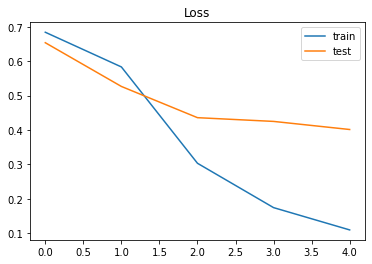

In [1019]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


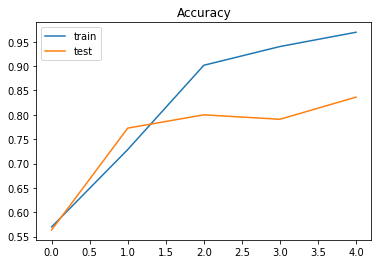

In [1022]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [0]:
# Convert a collection of text documents to a matrix of token counts

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# vectorizer = CountVectorizer(analyzer=process_text)
# vectorizer = CountVectorizer(ngram_range=(2, 4))
# vectorizer = HashingVectorizer(ngram_range=(2, 4),alternate_sign=False)
vectorizer = TfidfVectorizer(
    # strip_accents='unicode', 
    # analyzer='word', 
    ngram_range=(1,3), 
    # norm='l2', 
    # max_features = 15000
    # max_features = 12000
    max_features = 10000
    # max_features = 8000
    # max_features = 5000
    )

# vectorizer = TfidfVectorizer(ngram_range=(2, 4))
# vectorizer.fit(X_train)
# vectorizer.get_feature_names()


In [976]:
print("Shape of document term matrix")

# X_train_dtm = vectorizer.transform(X_train)
X_train_dtm = vectorizer.fit_transform(X_train)
print(f"Train: {X_train_dtm.shape}")

# prayer_bag_of_words = vectorizer.fit_transform(all_prayer_df['En'])
X_test_dtm = vectorizer.transform(X_test)
print(f"Test: {X_test_dtm.shape}")


Shape of document term matrix
Train: (976, 10000)
Test: (245, 10000)


In [0]:

# print(vectorizer.get_feature_names())


In [982]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB

classifier = MultinomialNB()
# classifier = ComplementNB()

# for Gaussian need array format
# X_train = X_train.toarray()
# X_test = X_test.toarray()
# classifier = GaussianNB()
# classifier = BernoulliNB()

%time classifier.fit(X_train_dtm, y_train)
y_pred_class = classifier.predict(X_test_dtm)
from sklearn import metrics

print(f"\nBreakdown:\n{y_test.value_counts()[0]} non-prayer (0), and\n{y_test.value_counts()[1]} prayer (1)")

null_accuracy = y_test.value_counts().head(1) / len(y_test)
print(f'\nNull accuracy: {null_accuracy[0]}')

non_prayer_passages = y_test.value_counts()[0]
prayer_passages = y_test.value_counts()[1]
print('Manual null accuracy:',(prayer_passages / (prayer_passages + non_prayer_passages)))

print('\nAccuracy:',round(metrics.accuracy_score(y_test, y_pred_class),2))
print('Precision:',round(metrics.precision_score(y_test, y_pred_class),2))
print('Recall:',round(metrics.recall_score(y_test, y_pred_class),2))
print('F1 score:',round(metrics.f1_score(y_test, y_pred_class),2))

print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_class))


CPU times: user 4.47 ms, sys: 13 µs, total: 4.48 ms
Wall time: 4.09 ms

Breakdown:
125 non-prayer (0), and
120 prayer (1)

Null accuracy: 0.5102040816326531
Manual null accuracy: 0.4897959183673469

Accuracy: 0.86
Precision: 0.85
Recall: 0.87
F1 score: 0.86

Confusion Matrix:
[[106  19]
 [ 16 104]]


In [983]:

from sklearn.model_selection import cross_val_score
# clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(classifier, X, y, cv=5)
scores


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'besought lord deuteronomi 323 halacha jew stand pray amidah prayer may pray loud sage teach talmud berachot 31a someon stand pray amidah prayer hear voic other chanah alreadi explain samuel 113 chanah spoke one might think one pray three amidah prayer throughout day singl prayer daniel alreadi taught daniel 611 three time day would kneel knee would pray bow god one might think one pray everi moment one fanci david alreadi explain psalm 5518 even morn afternoon speak moan hearken voic'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: cou

array([nan, nan, nan, nan, nan])

In [979]:
TP = X_test[y_pred_class + y_test == 2]
TN = X_test[y_pred_class + y_test == 0]
FP = X_test[y_pred_class > y_test]
FN = X_test[y_pred_class < y_test]

pd.options.display.max_colwidth = 100

# pd.style.set_properties(**{'text-align': 'left'})

# print("\n*** TP ***")
# print(TP.sample(5))
# print("\n*** TN ***")
# print(TN.sample(5))
print("*** False Positives: Actually NOT prayer, but misclassified as prayer ***\n")
print(FP.sample(10))
print("\n\n*** False Negatives: Actually prayer, but misclassified as NOT prayer ***\n")
print(FN.sample(10))

*** False Positives: Actually NOT prayer, but misclassified as prayer ***

1683    biblic proof cite deriv torah good deed requir bolster state instruct joshua strong extrem coura...
1780    2 concept sanctifi name god aspect benevol sever initi person inspir flame love correspond benev...
1256                                                         fals balanc abomin lord perfect weight delight
1408    name rav rabbi yehuda said futur holi one bless rejoic righteous let shechinah dwell among every...
1584    numb 2014 cont know troubl befallen us said know holi one said abraham gen 1513 know full well s...
1071                                  shall know lord god brought forth land egypt may dwell among lord god
1241    isaiah said unto thus shall ye say master thus saith lord afraid word thou hast heard wherewith ...
1141    torah also want go record entir preced 40 year mose faith shepherd peopl israel never spoke hars...
1430    happen two manner one possibl come rectifi seen perso

In [0]:
# FP.to_csv('FP', sep='\t', encoding='utf-8')
# FN.to_csv('FN', sep='\t', encoding='utf-8')
